In [1]:
cd ../SPADE/

/home/hpc/i9vl/i9vl106h/SPADE


In [2]:
from glob import glob
import os

In [16]:
files = glob("/home/woody/i9vl/i9vl106h/data/lidar4d_data/ground_truth/*.png")

In [17]:
files_300 = glob("/home/woody/i9vl/i9vl106h/data/lidar4d_data_res_300/ground_truth/*.png")
files_600 = glob("/home/woody/i9vl/i9vl106h/data/lidar4d_data_res_600/ground_truth/*.png")

In [9]:
len(files)#, len(files_300)

236

In [18]:
files_common = [f for f in files if os.path.basename(f) in [os.path.basename(g) for g in files_300 if os.path.basename(g) in [os.path.basename(h) for h in files_600]]]

In [19]:
basename_common = [os.path.basename(f) for f in files_common]

In [68]:
comp_dirs = glob("/home/woody/i9vl/i9vl106h/data/lidar4d_data/preds_*_500*")

In [69]:
comp_dirs_p2p = glob("/home/woody/i9vl/i9vl106h/data/lidar4d_data/preds_*_channel_latest*")

In [54]:
comp_dirs = comp_dirs + comp_dirs_p2p

NameError: name 'comp_dirs_p2p' is not defined

In [4]:
import os
from PIL import Image
import numpy as np
import shutil

In [7]:
# import l1 and l2 loss 
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

In [8]:
import lpips
import torch
import json
# loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
# loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

# import torch
# img0 = torch.zeros(1,3,64,64) # image should be RGB, IMPORTANT: normalized to [-1,1]
# img1 = torch.zeros(1,3,64,64)
# d = loss_fn_alex(img0, img1)

In [9]:
lpips_vgg = lpips.LPIPS(net='alex')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/woody/i9vl/i9vl106h/software/privat/conda/envs/spade/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/woody/i9vl/i9vl106h/software/privat/conda/envs/spade/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/woody/i9vl/i9vl106h/software/privat/conda/envs/spade/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth


In [10]:
from PIL import Image
import os

In [69]:
files = files_common

NameError: name 'files_common' is not defined

In [11]:
comp_dirs

NameError: name 'comp_dirs' is not defined

In [12]:
comp_dirs = sorted(glob(f"/home/woody/i9vl/i9vl106h/data/lidar4d_data/preds_spade*400")) 

In [92]:
comp_dirs = comp_dirs[1:]

In [93]:
normalized_by_mask = False
metric_dict = {}
# epoch_list = [100, 200, 300, 400, 500, 600]
# for epoch in epoch_list:
# comp_dirs = glob(f"/home/woody/i9vl/i9vl106h/data/lidar4d_data/preds_spade_test*")
# keys are the names of the directories in comp_dirs
# get average mse and ssim for each directory

for comp_dir in comp_dirs:
    mse = 0
    ssim = 0
    l1 = 0
    psnr = 0
    lpips = 0
    # files = glob(os.path.join(comp_dir, "*.png"))
    for file in files:
        # read with PIL and convert to grayscale 
        img = np.array(Image.open(file).convert("L"))
        
        # skip if the image is all black
        if np.sum(img) == 0:
            continue

        pred = np.array(Image.open(os.path.join(comp_dir, os.path.basename(file))).convert("L"))
        # scale to [0, 1] 
        # img = img / 255
        # pred = pred / 255

        mask = img > 0
        black = np.zeros_like(img)

        img = np.where(mask, img, black)
        pred = np.where(mask, pred, black)

        mse += mean_squared_error(img, pred)
        ssim += structural_similarity(img, pred)
        l1 += np.sum(np.abs(img - pred))
        # to fix the division by zero error
        # to fix the division by zero error
        psnr += peak_signal_noise_ratio(img, pred)

        img = torch.tensor(img).unsqueeze(0).unsqueeze(0).float()
        pred = torch.tensor(pred).unsqueeze(0).unsqueeze(0).float()
        
        # repeat the image 3 times to make it RGB
        img = torch.cat((img, img, img), dim=1)
        pred = torch.cat((pred, pred, pred), dim=1)

        # normalize to [-1, 1]
        img = img / 255 * 2 - 1
        pred = pred / 255 * 2 - 1

        lpips += lpips_vgg(img, pred).item()
        if normalized_by_mask:
            mse /= np.sum(mask)
            ssim /= np.sum(mask)
            l1 /= np.sum(mask)
            psnr /= np.sum(mask)
            lpips /= np.sum(mask)
        
    mse /= len(files)
    ssim /= len(files)
    l1 /= len(files)
    psnr /= len(files)
    lpips /= len(files)
    metric_dict[os.path.basename(comp_dir)] = {"mse": mse, "ssim": ssim, "l1": l1, "psnr": psnr, "lpips": lpips}
    
common_dir = os.path.commonpath(comp_dirs)
# is_masked = "_mask_normalized" if normalized_by_mask else ""
# with open(f"{common_dir}/qualitative/{epoch}{is_masked}_metrics.json", "w") as f:
#     json.dump(metric_dict, f)

In [94]:
metric_dict

{'preds_spade_test_7_lidar_data_masked_400': {'mse': 46.26438795608945,
  'ssim': 0.787831771951005,
  'l1': 2934953.0084745763,
  'psnr': 30.18314343515225,
  'lpips': 0.11335958774059506},
 'preds_spade_test_8_lidar_data_masked_no_data_400': {'mse': 18.725678767517998,
  'ssim': 0.8415110720168346,
  'l1': 2088167.3516949152,
  'psnr': 33.51361068456629,
  'lpips': 0.05233675085986823},
 'preds_spade_test_8_lidar_data_vanilla_400': {'mse': 31.727307821383974,
  'ssim': 0.7370249177007994,
  'l1': 1416731.0127118644,
  'psnr': 31.325226509492083,
  'lpips': 0.18039518493717}}

In [87]:
metric_dict

{'preds_spade_test_6_single_channel_700': {'mse': 19.027475721899595,
  'ssim': 0.836193459347506,
  'l1': 1942385.4449152541,
  'psnr': 33.44396893218811,
  'lpips': 0.06196368872424809}}

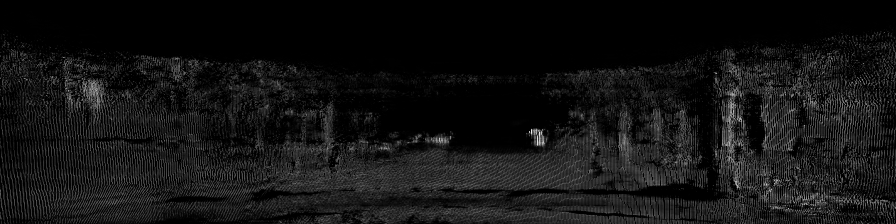

In [ ]:
Image.open(file).convert("L")

In [ ]:
mse = 0
ssim = 0
l1 = 0
psnr = 0
lpips = 0
files = glob(os.path.join(comp_dir, "*.png"))
# for file in files:
# read with PIL and convert to grayscale 
img = np.array(Image.open(file).convert("L"))
    
# skip if the image is all black
# if np.sum(img) == 0:
#     continue

pred = np.array(Image.open(os.path.join(comp_dir, os.path.basename(file))).convert("L"))
# scale to [0, 1] 
# img = img / 255
# pred = pred / 255

mask = img > 0
black = np.zeros_like(img)

img = np.where(mask, img, black)
pred = np.where(mask, pred, black)

mse += mean_squared_error(img, pred)
ssim += structural_similarity(img, pred)
l1 += np.sum(np.abs(img - pred))
# to fix the division by zero error
# to fix the division by zero error
psnr += peak_signal_noise_ratio(img, pred)

# img = torch.tensor(img).unsqueeze(0).unsqueeze(0).float()
# pred = torch.tensor(pred).unsqueeze(0).unsqueeze(0).float()

# # repeat the image 3 times to make it RGB
# img = torch.cat((img, img, img), dim=1)
# pred = torch.cat((pred, pred, pred), dim=1)

/home/woody/i9vl/i9vl106h/software/privat/conda/envs/spade/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


array([[ 0,  0,  0, ...,  0,  0,  3],
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 5, 39,  0, ...,  0, 56,  0],
       [ 5, 45,  0, ...,  0, 61,  1],
       [ 6, 39,  4, ..., 30,  0, 39]], dtype=uint8)

In [ ]:
# save the metric_dict

import json

In [ ]:
cd /home/woody/i9vl/i9vl106h/data/lidar4d_data

/home/woody/i9vl/i9vl106h/data/lidar4d_data


In [13]:
from PIL import Image
import numpy as np

In [42]:
comp_dirs = glob(f"/home/woody/i9vl/i9vl106h/data/lidar4d_data/preds_spade*single*_700")

In [43]:
comp_dirs

['/home/woody/i9vl/i9vl106h/data/lidar4d_data/preds_spade_test_6_single_channel_700']

In [30]:
comp_dirs = [dir for dir in comp_dirs if "6_lidar_data_400" not in dir]

In [32]:
# files_to_copy_qualitative = ["0000_0000010797.png", "0000_0000002409.png", "0000_0000010769.png"]
files_to_copy_qualitative = basename_common
# copy the files to a new directory prepending the name of the directory

import shutil
# add "ground_truth" to the list of directories to copy
gt = comp_dirs[0].replace(os.path.basename(comp_dirs[0]), "ground_truth")

comp_dirs = [gt] + comp_dirs

rgb = comp_dirs[0].replace("ground_truth", "rgb")

comp_dirs = [rgb] + comp_dirs

In [44]:
comp_dirs

['/home/woody/i9vl/i9vl106h/data/lidar4d_data/preds_spade_test_6_single_channel_700']

In [46]:
for comp_dir in comp_dirs:
    for file in files_to_copy_qualitative:
        # open the image and check if it is all black
        img = Image.open(os.path.join(comp_dir, file))
        
        # convert to grayscale and convert to numpy array
        # if file has "rgb" in the name, it is a 3 channel image
        if "rgb" in comp_dir:
            # directly save the image
            img.save(os.path.join(os.path.commonpath(comp_dirs), "qualitative", os.path.basename(comp_dir) + "_" + file))
            continue
            
        img = np.array(img)
        if np.sum(img) == 0:
            print("skipping", file)
            continue
        # increase intensity of the image x 3
        img = img * 3
        img = Image.fromarray(img)
        basename = os.path.basename(comp_dir)
        # remove the postfix _400 or _200 if it exists
        if basename.split("_")[-1].isdigit():
            basename = "_".join(basename.split("_")[:-1])

        img.save(os.path.join(os.path.commonpath(comp_dirs), "qualitative", basename + "_" + file))
        # shutil.copyfile(os.path.join(comp_dir, file), os.path.join(os.path.commonpath(comp_dirs), "qualitative", os.path.basename(comp_dir) + "_" + file))


In [35]:
basename_common 

['0000_0000000575.png',
 '0000_0000004986.png',
 '0000_0000008151.png',
 '0000_0000003058.png',
 '0000_0000002427.png',
 '0000_0000004992.png',
 '0000_0000010769.png',
 '0000_0000004998.png']

In [2]:
cd ../SPADE/

/home/hpc/i9vl/i9vl106h/SPADE


In [3]:
import sys
import numpy as np
from collections import OrderedDict
from options.train_options import TrainOptions
import data
from util.iter_counter import IterationCounter
from util.visualizer import Visualizer
from trainers.pix2pix_trainer import Pix2PixTrainer

from models.pix2pix_model import Pix2PixModel
from util import util
import os
from glob import glob

args = "--name spade_res_300_vanilla --dataset_mode pix2pix --dataroot /home/woody/i9vl/i9vl106h/data/lidar4d_data --no_instance --label_nc 0 --preprocess_mode fixed_wh --load_size 1000 --crop 896 --aspect_ratio 4 --display_freq 5000 --niter 1000 --batchSize 4 --use_masked_training --checkpoints_dir /home/woody/i9vl/i9vl106h/logs --output_nc 1 --continue_train"
sys.argv = [sys.argv[0], *args.split()]

opt = TrainOptions().parse()
opt.isTrain = False

# print options to help debugging
print(' '.join(sys.argv))

# load the dataset
dataloader = data.create_dataloader(opt)



In [40]:
names = [os.path.basename(f) for f in glob(f"{opt.checkpoints_dir}/spade_test_6_single_*") if os.path.exists(os.path.join(f, "iter.txt")) and int(open(os.path.join(f, "iter.txt"), "r").readline().strip()) > 150]
# names = [name for name in names if "6_lidar_data" not in name]

In [41]:
names

['spade_test_6_single_channel']

In [42]:
for epoch in [700]:
    opt.which_epoch = epoch
    for name in names:
        opt.name = name
        # if "lidar" not in opt.name:
        #     opt.which_epoch = int(np.ceil((opt.which_epoch // 2)//10)*10)
        #     # min of opt.which_epoch or iter from file
        #     iter_file = int(open(f"{opt.checkpoints_dir}/{opt.name}/iter.txt", "r").readline().strip())
            # opt.which_epoch = np.where(iter_file < opt.which_epoch, "latest", opt.which_epoch)

        pix2pixmodel = Pix2PixModel(opt)
        pix2pixmodel.eval()

        
        # create trainer for our model
        trainer = Pix2PixTrainer(opt)

        for i, data_i in enumerate(dataloader):
            out = pix2pixmodel(data_i, mode='inference')
            paths_out = [path.replace('test_B', f'preds_{opt.name}_{opt.which_epoch}') for path in data_i['path']]

            for path, img in zip(paths_out, out):
                image_numpy = util.tensor2im(img)
                util.save_image(image_numpy, path, create_dir=True)


Network [SPADEGenerator] was created. Total number of parameters: 92.1 million. To see the architecture, do print(network).
Network [SPADEGenerator] was created. Total number of parameters: 92.1 million. To see the architecture, do print(network).


In [ ]:
path

'/home/woody/i9vl/i9vl106h/data/lidar4d_data_res_600/preds_spade_res_600_vanilla_700/0000_0000002363.png'

In [ ]:
opt.name = "spade_test_8_lidar_data_vanilla"
opt.which_epoch = 400
if "lidar" not in opt.name:
    opt.which_epoch = int(np.ceil((opt.which_epoch // 4)//10)*10)

In [ ]:
pix2pixmodel = Pix2PixModel(opt)
pix2pixmodel.eval()

Network [SPADEGenerator] was created. Total number of parameters: 92.1 million. To see the architecture, do print(network).


Pix2PixModel(
  (netG): SPADEGenerator(
    (fc): Conv2d(3, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (head_0): SPADEResnetBlock(
      (conv_0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm_0): SPADE(
        (param_free_norm): SynchronizedBatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (mlp_shared): Sequential(
          (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): ReLU()
        )
        (mlp_gamma): Conv2d(128, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (mlp_beta): Conv2d(128, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm_1): SPADE(
        (param_free_norm): SynchronizedBatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (mlp_shared): Sequential(
          (0): Conv2d

In [ ]:

# create trainer for our model
trainer = Pix2PixTrainer(opt)

# create tool for counting iterations
# iter_counter = IterationCounter(opt, len(dataloader) * opt.batchSize)

# # # create tool for visualization
# visualizer = Visualizer(opt)



Network [SPADEGenerator] was created. Total number of parameters: 92.1 million. To see the architecture, do print(network).


In [ ]:
if opt.which_epoch == "latest":
    f = os.path.join(opt.checkpoints_dir, opt.name, "iter.txt")
    with open(f, "r") as file:
        opt.which_epoch = int(file.readline())

In [ ]:
for i, data_i in enumerate(dataloader):
    # out = pix2pixmodel(data_i, mode='inference')
    # paths_out = [path.replace('test_B', f'preds_{opt.name}_{opt.which_epoch}') for path in data_i['path']]

    # for path, img in zip(paths_out, out):
    #     image_numpy = util.tensor2im(img)
    #     util.save_image(image_numpy, path, create_dir=True)

    # save the ground truth
    paths_gt = [path.replace('test_B', f'ground_truth') for path in data_i['path']]
    for path, img in zip(paths_gt, data_i['image']):
        image_numpy = util.tensor2im(img)
        util.save_image(image_numpy, path, create_dir=True)

    # save the rgb images
    paths_rgb = [path.replace('test_B', f'rgb') for path in data_i['path']]
    for path, img in zip(paths_rgb, data_i['label']):
        image_numpy = util.tensor2im(img)
        util.save_image(image_numpy, path, create_dir=True)

In [ ]:
data_i['image'].shape

torch.Size([4, 1, 224, 896])

In [ ]:
out.shape

torch.Size([4, 1, 224, 896])

In [ ]:
first_batch = next(iter(dataloader))

In [ ]:
import torch

In [ ]:
first_batch['image'].shape

# mask TOP 40% of the image vertically

mask = torch.zeros_like(first_batch['image'])
mask[:, :, (mask.size(2) // 5)*2:, :] = 1

In [ ]:
single_mask_cpu = mask[0].cpu().numpy()

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
single_mask_cpu[0, :10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

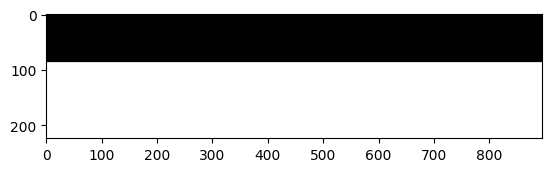

In [ ]:
plt.imshow(single_mask_cpu[0], cmap='gray')

In [ ]:
import torch
from PIL import Image

In [ ]:
mask_1 = first_batch['mask'][3][0].detach().cpu().numpy()
lidar_1 = first_batch['image'][3][0].detach().cpu().numpy()

In [ ]:
lidar_1_masked = np.where(~mask_1, lidar_1, 255)

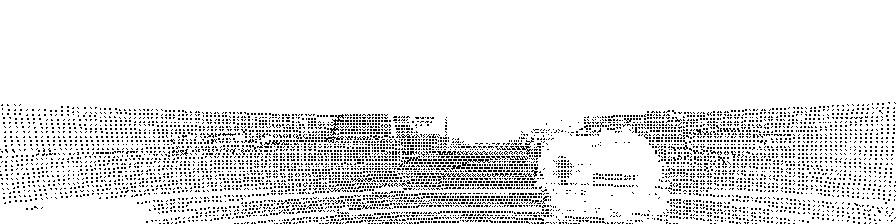

In [ ]:
Image.fromarray((lidar_1_masked).astype(np.uint8))

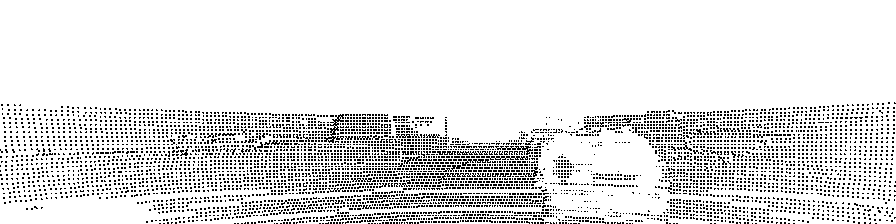

In [ ]:
Image.fromarray((lidar_1).astype(np.uint8))

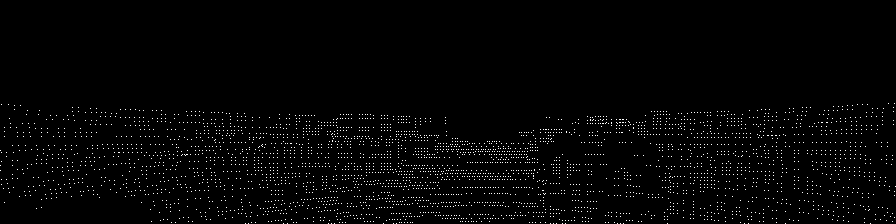

In [ ]:
Image.fromarray((mask_1 * 255).astype(np.uint8))

In [ ]:
first_batch['label'].shape

torch.Size([4, 3, 224, 896])

In [ ]:
from PIL import Image

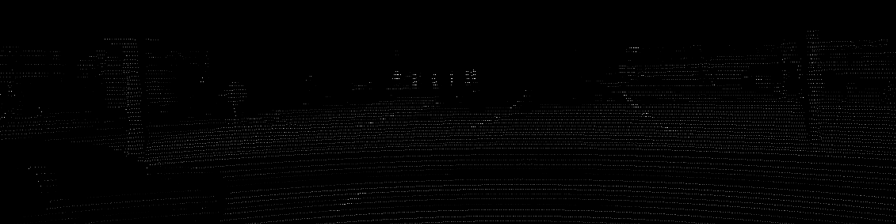

In [ ]:
Image.fromarray((((first_batch['image'][0,0].cpu().numpy()+1)/2)*255).astype(np.uint8))

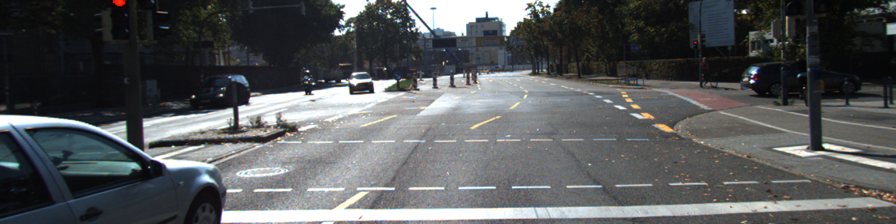

In [ ]:
Image.fromarray((((first_batch['label'].permute(0, 2, 3, 1).cpu().numpy()[0]+1)/2)*255).astype(np.uint8))

In [ ]:
clear_iter = False

In [ ]:
opt.use_masked_training = False

In [ ]:
data = next(iter(dataloader))

In [ ]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

import torch
import models.networks as networks
import util.util as util


class Pix2PixModel(torch.nn.Module):
    @staticmethod
    def modify_commandline_options(parser, is_train):
        networks.modify_commandline_options(parser, is_train)
        return parser

    def __init__(self, opt):
        super().__init__()
        self.opt = opt
        self.FloatTensor = torch.cuda.FloatTensor if self.use_gpu() \
            else torch.FloatTensor
        self.ByteTensor = torch.cuda.ByteTensor if self.use_gpu() \
            else torch.ByteTensor

        self.netG, self.netD, self.netE = self.initialize_networks(opt)

        # set loss functions
        if opt.isTrain:
            self.criterionGAN = networks.GANLoss(
                opt.gan_mode, tensor=self.FloatTensor, opt=self.opt)
            self.criterionFeat = torch.nn.L1Loss()
            if not opt.no_vgg_loss:
                self.criterionVGG = networks.VGGLoss(self.opt.gpu_ids)
            if opt.use_vae:
                self.KLDLoss = networks.KLDLoss()

    # Entry point for all calls involving forward pass
    # of deep networks. We used this approach since DataParallel module
    # can't parallelize custom functions, we branch to different
    # routines based on |mode|.
    def forward(self, data, mode):
        input_semantics, real_image = self.preprocess_input(data)
        return input_semantics, real_image
        if mode == 'generator':
            g_loss, generated = self.compute_generator_loss(
                input_semantics, real_image)
            return g_loss, generated
        elif mode == 'discriminator':
            d_loss = self.compute_discriminator_loss(
                input_semantics, real_image)
            return d_loss
        elif mode == 'encode_only':
            z, mu, logvar = self.encode_z(real_image)
            return mu, logvar
        elif mode == 'inference':
            with torch.no_grad():
                fake_image, _ = self.generate_fake(input_semantics, real_image)
            return fake_image
        else:
            raise ValueError("|mode| is invalid")

    def create_optimizers(self, opt):
        G_params = list(self.netG.parameters())
        if opt.use_vae:
            G_params += list(self.netE.parameters())
        if opt.isTrain:
            D_params = list(self.netD.parameters())

        beta1, beta2 = opt.beta1, opt.beta2
        if opt.no_TTUR:
            G_lr, D_lr = opt.lr, opt.lr
        else:
            G_lr, D_lr = opt.lr / 2, opt.lr * 2

        optimizer_G = torch.optim.Adam(G_params, lr=G_lr, betas=(beta1, beta2))
        optimizer_D = torch.optim.Adam(D_params, lr=D_lr, betas=(beta1, beta2))

        return optimizer_G, optimizer_D

    def save(self, epoch):
        util.save_network(self.netG, 'G', epoch, self.opt)
        util.save_network(self.netD, 'D', epoch, self.opt)
        if self.opt.use_vae:
            util.save_network(self.netE, 'E', epoch, self.opt)

    ############################################################################
    # Private helper methods
    ############################################################################

    def initialize_networks(self, opt):
        netG = networks.define_G(opt)
        netD = networks.define_D(opt) if opt.isTrain else None
        netE = networks.define_E(opt) if opt.use_vae else None

        if not opt.isTrain or opt.continue_train:
            netG = util.load_network(netG, 'G', opt.which_epoch, opt)
            if opt.isTrain:
                netD = util.load_network(netD, 'D', opt.which_epoch, opt)
            if opt.use_vae:
                netE = util.load_network(netE, 'E', opt.which_epoch, opt)

        return netG, netD, netE

    # preprocess the input, such as moving the tensors to GPUs and
    # transforming the label map to one-hot encoding
    # |data|: dictionary of the input data

    def preprocess_input(self, data):
        if self.opt.label_nc == 0:
            if self.use_gpu():
                return data['label'].cuda(), data['image'].cuda()
            else:
                return data['label'], data['image']
        # move to GPU and change data types
        data['label'] = data['label'].long()
        if self.use_gpu():
            data['label'] = data['label'].cuda()
            data['instance'] = data['instance'].cuda()
            data['image'] = data['image'].cuda()
            
        # create one-hot label map
        label_map = data['label']
        bs, _, h, w = label_map.size()
        nc = self.opt.label_nc + 1 if self.opt.contain_dontcare_label \
            else self.opt.label_nc
        input_label = self.FloatTensor(bs, nc, h, w).zero_()
        input_semantics = input_label.scatter_(1, label_map, 1.0)

        # concatenate instance map if it exists
        if not self.opt.no_instance:
            inst_map = data['instance']
            instance_edge_map = self.get_edges(inst_map)
            input_semantics = torch.cat((input_semantics, instance_edge_map), dim=1)

        return input_semantics, data['image']

    def compute_generator_loss(self, input_semantics, real_image):
        G_losses = {}

        fake_image, KLD_loss = self.generate_fake(
            input_semantics, real_image, compute_kld_loss=self.opt.use_vae)
        
        if self.opt.use_masked_training:
            mask = real_image == -1
            fake_image_ = torch.where(mask, -1, fake_image)
        else:
            fake_image_ = fake_image

        if self.opt.use_vae:
            G_losses['KLD'] = KLD_loss

        pred_fake, pred_real = self.discriminate(
            input_semantics, fake_image_, real_image)

        G_losses['GAN'] = self.criterionGAN(pred_fake, True,
                                            for_discriminator=False)

        if not self.opt.no_ganFeat_loss:
            num_D = len(pred_fake)
            GAN_Feat_loss = self.FloatTensor(1).fill_(0)
            for i in range(num_D):  # for each discriminator
                # last output is the final prediction, so we exclude it
                num_intermediate_outputs = len(pred_fake[i]) - 1
                for j in range(num_intermediate_outputs):  # for each layer output
                    unweighted_loss = self.criterionFeat(
                        pred_fake[i][j], pred_real[i][j].detach())
                    GAN_Feat_loss += unweighted_loss * self.opt.lambda_feat / num_D
            G_losses['GAN_Feat'] = GAN_Feat_loss

        if not self.opt.no_vgg_loss:
            G_losses['VGG'] = self.criterionVGG(fake_image_, real_image) \
                * self.opt.lambda_vgg

        return G_losses, fake_image

    def compute_discriminator_loss(self, input_semantics, real_image):
        D_losses = {}
        with torch.no_grad():
            fake_image, _ = self.generate_fake(input_semantics, real_image)
            fake_image = fake_image.detach()
            fake_image.requires_grad_()

        
        if self.opt.use_masked_training:
            mask = real_image == -1
            fake_image_ = torch.where(mask, -1, fake_image)
        else:
            fake_image_ = fake_image

        pred_fake, pred_real = self.discriminate(
            input_semantics, fake_image_, real_image)

        D_losses['D_Fake'] = self.criterionGAN(pred_fake, False,
                                               for_discriminator=True)
        D_losses['D_real'] = self.criterionGAN(pred_real, True,
                                               for_discriminator=True)

        return D_losses

    def encode_z(self, real_image):
        mu, logvar = self.netE(real_image)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def generate_fake(self, input_semantics, real_image, compute_kld_loss=False):
        z = None
        KLD_loss = None
        if self.opt.use_vae:
            z, mu, logvar = self.encode_z(real_image)
            if compute_kld_loss:
                KLD_loss = self.KLDLoss(mu, logvar) * self.opt.lambda_kld

        fake_image = self.netG(input_semantics, z=z)

        assert (not compute_kld_loss) or self.opt.use_vae, \
            "You cannot compute KLD loss if opt.use_vae == False"

        return fake_image, KLD_loss

    # Given fake and real image, return the prediction of discriminator
    # for each fake and real image.

    def discriminate(self, input_semantics, fake_image, real_image):
        fake_concat = torch.cat([input_semantics, fake_image], dim=1)
        real_concat = torch.cat([input_semantics, real_image], dim=1)

        # In Batch Normalization, the fake and real images are
        # recommended to be in the same batch to avoid disparate
        # statistics in fake and real images.
        # So both fake and real images are fed to D all at once.
        fake_and_real = torch.cat([fake_concat, real_concat], dim=0)

        discriminator_out = self.netD(fake_and_real)

        pred_fake, pred_real = self.divide_pred(discriminator_out)

        return pred_fake, pred_real

    # Take the prediction of fake and real images from the combined batch
    def divide_pred(self, pred):
        # the prediction contains the intermediate outputs of multiscale GAN,
        # so it's usually a list
        if type(pred) == list:
            fake = []
            real = []
            for p in pred:
                fake.append([tensor[:tensor.size(0) // 2] for tensor in p])
                real.append([tensor[tensor.size(0) // 2:] for tensor in p])
        else:
            fake = pred[:pred.size(0) // 2]
            real = pred[pred.size(0) // 2:]

        return fake, real

    def get_edges(self, t):
        edge = self.ByteTensor(t.size()).zero_()
        edge[:, :, :, 1:] = edge[:, :, :, 1:] | (t[:, :, :, 1:] != t[:, :, :, :-1])
        edge[:, :, :, :-1] = edge[:, :, :, :-1] | (t[:, :, :, 1:] != t[:, :, :, :-1])
        edge[:, :, 1:, :] = edge[:, :, 1:, :] | (t[:, :, 1:, :] != t[:, :, :-1, :])
        edge[:, :, :-1, :] = edge[:, :, :-1, :] | (t[:, :, 1:, :] != t[:, :, :-1, :])
        return edge.float()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps.mul(std) + mu

    def use_gpu(self):
        return len(self.opt.gpu_ids) > 0


In [ ]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

from models.networks.sync_batchnorm import DataParallelWithCallback
# from models.pix2pix_model import Pix2PixModel


class Pix2PixTrainer():
    """
    Trainer creates the model and optimizers, and uses them to
    updates the weights of the network while reporting losses
    and the latest visuals to visualize the progress in training.
    """

    def __init__(self, opt):
        self.opt = opt
        self.pix2pix_model = Pix2PixModel(opt)
        if len(opt.gpu_ids) > 0:
            self.pix2pix_model = DataParallelWithCallback(self.pix2pix_model,
                                                          device_ids=opt.gpu_ids)
            self.pix2pix_model_on_one_gpu = self.pix2pix_model.module
        else:
            self.pix2pix_model_on_one_gpu = self.pix2pix_model

        self.generated = None
        if opt.isTrain:
            self.optimizer_G, self.optimizer_D = \
                self.pix2pix_model_on_one_gpu.create_optimizers(opt)
            self.old_lr = opt.lr

    def run_generator_one_step(self, data):
        self.optimizer_G.zero_grad()
        g_losses, generated = self.pix2pix_model(data, mode='generator')
        g_loss = sum(g_losses.values()).mean()
        g_loss.backward()
        self.optimizer_G.step()
        self.g_losses = g_losses
        self.generated = generated

    def run_discriminator_one_step(self, data):
        self.optimizer_D.zero_grad()
        d_losses = self.pix2pix_model(data, mode='discriminator')
        d_loss = sum(d_losses.values()).mean()
        d_loss.backward()
        self.optimizer_D.step()
        self.d_losses = d_losses

    def get_latest_losses(self):
        return {**self.g_losses, **self.d_losses}

    def get_latest_generated(self):
        return self.generated

    def update_learning_rate(self, epoch):
        self.update_learning_rate(epoch)

    def save(self, epoch):
        self.pix2pix_model_on_one_gpu.save(epoch)

    ##################################################################
    # Helper functions
    ##################################################################

    def update_learning_rate(self, epoch):
        if epoch > self.opt.niter:
            lrd = self.opt.lr / self.opt.niter_decay
            new_lr = self.old_lr - lrd
        else:
            new_lr = self.old_lr

        if new_lr != self.old_lr:
            if self.opt.no_TTUR:
                new_lr_G = new_lr
                new_lr_D = new_lr
            else:
                new_lr_G = new_lr / 2
                new_lr_D = new_lr * 2

            for param_group in self.optimizer_D.param_groups:
                param_group['lr'] = new_lr_D
            for param_group in self.optimizer_G.param_groups:
                param_group['lr'] = new_lr_G
            print('update learning rate: %f -> %f' % (self.old_lr, new_lr))
            self.old_lr = new_lr


In [ ]:

from models.pix2pix_model import Pix2PixModel
pix2pixmodel = Pix2PixModel(opt)

Network [SPADEGenerator] was created. Total number of parameters: 92.1 million. To see the architecture, do print(network).
Network [MultiscaleDiscriminator] was created. Total number of parameters: 5.5 million. To see the architecture, do print(network).


/home/woody/i9vl/i9vl106h/software/privat/conda/envs/spade/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/woody/i9vl/i9vl106h/software/privat/conda/envs/spade/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

# create trainer for our model
trainer = Pix2PixTrainer(opt)

# create tool for counting iterations
# iter_counter = IterationCounter(opt, len(dataloader) * opt.batchSize)

# # create tool for visualization
# visualizer = Visualizer(opt)



Network [SPADEGenerator] was created. Total number of parameters: 92.1 million. To see the architecture, do print(network).
Network [MultiscaleDiscriminator] was created. Total number of parameters: 5.5 million. To see the architecture, do print(network).


In [ ]:
pix2pixmodel.netG

SPADEGenerator(
  (fc): Conv2d(3, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (head_0): SPADEResnetBlock(
    (conv_0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm_0): SPADE(
      (param_free_norm): SynchronizedBatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (mlp_shared): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (mlp_gamma): Conv2d(128, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mlp_beta): Conv2d(128, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (norm_1): SPADE(
      (param_free_norm): SynchronizedBatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (mlp_shared): Sequential(
        (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
input_semantics, real_image = pix2pixmodel.preprocess_input(first_batch)

In [ ]:
real_image.shape

torch.Size([4, 1, 224, 896])

In [ ]:
fake_image, _ = pix2pixmodel.generate_fake(input_semantics, real_image)

/home/woody/i9vl/i9vl106h/software/privat/conda/envs/spade/lib/python3.7/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
fake_image.shape

torch.Size([4, 3, 224, 896])

In [ ]:
im = (real_image[0].permute(1, 2, 0).cpu().numpy()+1)/2

In [ ]:
from PIL import Image

In [ ]:
im.min()

0.0

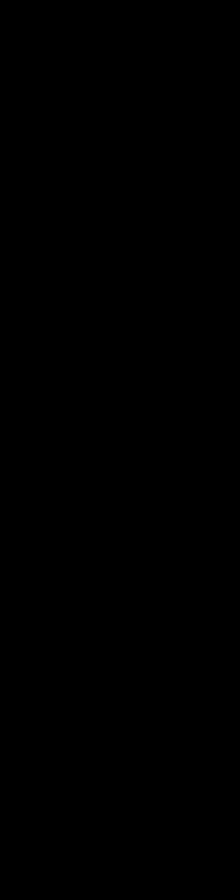

In [ ]:
Image.fromarray((im * 255).astype(np.uint8))

In [ ]:
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
trainer.optimizer_G.zero_grad()
g_losses, generated = trainer.pix2pix_model(data, mode='generator')


/home/woody/i9vl/i9vl106h/software/privat/conda/envs/spade/lib/python3.7/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1000 but got size 896 for tensor number 1 in the list.

In [ ]:
for epoch in iter_counter.training_epochs():
    iter_counter.record_epoch_start(epoch, clear_iter)
    clear_iter = True

    start_batch_idx = iter_counter.epoch_iter // opt.batchSize
    
    for i, data_i in enumerate(dataloader):
        if i < start_batch_idx:
            continue

        iter_counter.record_one_iteration()

        # Training
        # train generator
        if i % opt.D_steps_per_G == 0:
            trainer.run_generator_one_step(data_i)

        # train discriminator
        trainer.run_discriminator_one_step(data_i)

        # Visualizations
        if iter_counter.needs_printing():
            losses = trainer.get_latest_losses()
            visualizer.print_current_errors(epoch, iter_counter.epoch_iter,
                                            losses, iter_counter.time_per_iter)
            visualizer.plot_current_errors(losses, iter_counter.total_steps_so_far)

        if iter_counter.needs_displaying():
            visuals = OrderedDict([('input_label', data_i['label']),
                                   ('synthesized_image', trainer.get_latest_generated()),
                                   ('real_image', data_i['image'])])
            visualizer.display_current_results(visuals, epoch, iter_counter.total_steps_so_far)

        if iter_counter.needs_saving():
            print('saving the latest model (epoch %d, total_steps %d)' %
                  (epoch, iter_counter.total_steps_so_far))
            trainer.save('latest')
            iter_counter.record_current_iter()
        
    trainer.update_learning_rate(epoch)
    iter_counter.record_epoch_end()

    if epoch % opt.save_epoch_freq == 0 or \
       epoch == iter_counter.total_epochs:
        print('saving the model at the end of epoch %d, iters %d' %
              (epoch, iter_counter.total_steps_so_far))
        trainer.save('latest')
        trainer.save(epoch)
        

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1000 but got size 896 for tensor number 1 in the list.